# Necessities

## Libraries

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import hydrant.topology.geom as gm

import os

## Paths

In [2]:
root_path = os.path.join(os.getcwd(), '../../../../', 'geofabric', 'modified_TGF', 'smm_tgf_modified')

cat_path = os.path.join(root_path, 'smm_cat.shp')
riv_path = os.path.join(root_path, 'smm_riv.shp')

## Reading geometries

In [3]:
# reading geometries for catchments (cats) and rivers (rivs)
cats = gpd.read_file(cat_path)
rivs = gpd.read_file(riv_path)

In [4]:
# separating non-contributing areas (ncas) from contributing ones (cats)
ncas = cats[cats.seg_nhm == 0].copy()
cats = cats[cats.seg_nhm != 0].copy()

In [5]:
len(cats) + len(ncas) == len(rivs)
# so we have non-contributing areas where no rivers has been defined!

False

In [6]:
# do we have rivers defined for each catchments?
len(cats) == len(rivs)

True

In [7]:
# OK, so how many catchments we have without rivers, i.e., non-contributing catchments?
len(ncas)

14

In [8]:
cats.columns

Index(['hru_nhm', 'seg_nhm', 'POI_ID', 'hru_id', 'hru_segmen', 'hru_id_tb',
       'hru_segm_1', 'Type_NCA', 'HUC04', 'Coastal_HR', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [9]:
rivs.columns

Index(['seg_nhm', 'ds_seg_nhm', 'Main_ID', 'DS_Main_ID', 'seg_id', 'tosegment',
       'seg_id_tb', 'tosegment_', 'Type_Out', 'HUC04', 'Shape_Leng',
       'seg_slope', 'geometry'],
      dtype='object')

# Preparing catchments and rivers for final use

In [10]:
catchments = gm.prepare_cat(cat=cats,
                            cat_col_id='seg_nhm',
                            cst=ncas,
                            cst_col_mapper={'seg_nhm':'seg_nhm'},
                            cst_col_id='seg_nhm'
                           )

In [11]:
rivs.Shape_Leng = rivs.Shape_Leng.astype(float)

In [12]:
rivs.ds_seg_nhm = rivs.ds_seg_nhm.astype(int)

In [13]:
rivs.seg_slope = rivs.seg_slope.astype(float)

In [14]:
rivers = gm.prepare_riv(riv=rivs,
                        riv_cols={
                            'id':'seg_nhm',
                            'next_id':'ds_seg_nhm',
                            'slope':'seg_slope',
                            'length':'Shape_Leng'
                        },
                        cat=catchments,
                        cat_cols={
                            'id':'seg_nhm',
                            'hillslope':'hillslope',
                            'geom':'geometry'},
                        outlet_val=0, # to be consistent with the geofabric's assumption
                       )

In [15]:
# So, after modifications, are the lengths of `rivers` and `catchments` equal now?

len(rivers) == len(catchments)

True

# Plotting!

<AxesSubplot:>

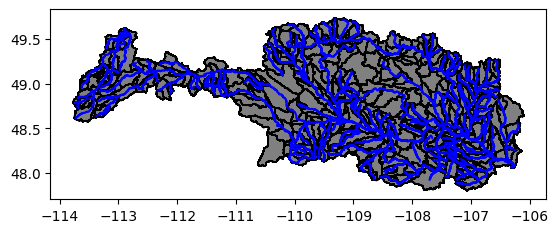

In [16]:
fig, ax = plt.subplots(1, 1)

# plot catchments
ax = catchments.plot(ax=ax, color='grey', edgecolor='black')

# plot rivers
rivers.plot(ax=ax, color='blue')

# Saving modified geofabric

In [17]:
# specify output path and create the directory, if doesn't exist 
geofabric_dir = os.path.join(os.getcwd(), 'geofabric')
os.makedirs(geofabric_dir)

# save geofabric
rivers.to_file(os.path.join(geofabric_dir, 'rivers.shp'))
catchments.to_file(os.path.join(geofabric_dir, 'catchments.shp'))